## Methods to compare in integration tasks

Harmony and Liger are widely-used data integration / batch effect correction methods that have Python implementations. Harmony is usually considered to be less aggressive in strength, thus keeping more biological variance. Liger is suitable in situations with more severe batch effect.

In [1]:
import scanpy as sc
import sklearn as skl
import pandas as pd
import matplotlib.pyplot as plt
import pickle as pkl

In [2]:
# Some utilities does not work on Windows. Consider using WSL2 on a Windows machine.
# Known probablematic ones: scib.me.clisi_graph
import scib

In [3]:
from tqdm import tqdm

In [4]:
import matplotlib as mpl

## Load data and view the data without integration

In [5]:
adata = sc.read_h5ad('output/human-brain-4000-integration.h5ad')

/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [6]:
with open("output/human-brain-4000-kuanglu-emb.pkl", 'rb') as f:
    adata.obsm['X_kuanglu'] = pkl.load(f)

## Scoring and plotting 

In [7]:
adata.obs.columns

Index(['global.x', 'global.y', 'adjusted.x', 'adjusted.y', 'fov.x', 'fov.y',
       'cluster_L1', 'cluster_L2', 'cluster_L3', 'sample'],
      dtype='object')

In [8]:
batch = 'sample'
label = 'cluster_L1'

In [9]:
ct = pd.crosstab(adata.obs[label], adata.obs[batch])
abundant_cell_types = ct.index[ct.min(axis=1) >= 3].tolist()
print(*abundant_cell_types, sep=', ')

EXC, INC, lASC, lMGC, lOGC, lOPC, oENDO, oMURAL


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/indexes/multi.py:643: DeprecationWarning: `cumproduct` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `cumprod` instead.
  codes = cartesian_product(codes)
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/reshape/util.py:60: DeprecationWarning: `product` is deprecated as of NumPy 1.25.0, and will be removed in NumPy 2.0. Please use `prod` instead.
  return [


In [10]:
adata = adata[adata.obs[label].isin(abundant_cell_types)]

/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])


In [11]:
methods = ('liger', 'harmony', 'pca', 'scanorama', 'kuanglu')
use_cosine = ['liger', 'scanorama']

In [12]:
scores = {}

for method in tqdm(methods):
    matrix_name = 'X_' + method
    
    if method in use_cosine:
        sc.pp.neighbors(adata, use_rep=matrix_name, metric='cosine')
    else:
        sc.pp.neighbors(adata, use_rep=matrix_name)
        
    s = skl.metrics.silhouette_score(adata.obsm[matrix_name], adata.obs[label])
    
    ilasw = scib.me.isolated_labels_asw(adata, batch_key=batch, label_key=label, embed=matrix_name)
    
    ilf1 = scib.me.isolated_labels_f1(adata, batch_key=batch, label_key=label, embed=None)
    
    db = skl.metrics.davies_bouldin_score(adata.obsm[matrix_name], adata.obs[label])
    ch = skl.metrics.calinski_harabasz_score(adata.obsm[matrix_name], adata.obs[label])
    clisi = scib.me.clisi_graph(adata, label_key=label, type_="knn")
    
    scores[method] = [s, ilasw, ilf1, db, ch, clisi]

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.702926969198001


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INC: 0.5775811718519066


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.648071335415765


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.6858761417974134


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.6533905080237159


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.714565404226297


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.723374304445797


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.5319080061983928
isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.9763581763581762


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INC: 0.9723897911832947


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.98543936462682


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.9442237406642301


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.9411365691890262


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.9615483209433479


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.9459297086212076


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.9103362391033624


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.6503752768039703


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INC: 0.5708895847201347


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.683839425444603


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.6676795929670334


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.7497443556785583
lOPC: 0.6525742709636688


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.6657655090093613
oMURAL: 0.628459170460701
isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.9210219318712085


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INC: 0.9746639705007731


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.9918300653594772


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.9686343895769665


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.9866942532015839


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.9781095786410224


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.9692010117542033


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.9461227032077235


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.58144411444664


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INC: 0.5514607019722462


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.6187157928943634


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.5858432799577713


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.6952941566705704
lOPC: 0.5989792048931122


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.6025454327464104
oMURAL: 0.5946267172694206
isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.6151501295534217


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INC: 0.736426167130104


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.7082457983193279


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.6811806573163073


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.5959212236329101


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.9769386720729852


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.6302065695902471


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.7339377217185652


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.5373504387514525
INC: 0.524294168524699


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.5600610880136736


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.5323113258054769


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.5860226114221792
lOPC: 0.5386444452367888


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.516810563089904
oMURAL: 0.5480694334021636
isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.7131423757371524


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INC: 0.7197648787656136


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.7040816326530611


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.5834592960483697


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.7196104309834797


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.6677724332393432


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.6167563930013459


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.7011308562197093


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.65703370006448
INC: 0.630315420315321


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.7206424866426108


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.7049009401962881


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.7392664476619152
lOPC: 0.6722149472803318


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.6659013665999215
oMURAL: 0.6728944267485367
isolated labels: no more than 10 batches per label


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


EXC: 0.9255838578739926


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


INC: 0.9843421360130871


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lASC: 0.9894222945484134


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lMGC: 0.9689029202841357


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOGC: 0.9907860639216816


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


lOPC: 0.9772241097269411


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oENDO: 0.96605122096486


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


oMURAL: 0.9446517412935324


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/anndata/_core/anndata.py:1838: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/dtypes/cast.py:1641: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  return np.find_common_type(types, [])
/home/lshh/minicon

In [13]:
scores = pd.DataFrame(scores, index=['silhouette', 'ilasw', 'ilf1', 'davies_bouldin', 'calinski_harabasz', 'cLISI']).T

In [14]:
scores = scores.loc[['kuanglu', 'scanorama', 'harmony', 'liger', 'pca']]
scores

,silhouette,ilasw,ilf1,davies_bouldin,calinski_harabasz,cLISI
kuanglu,0.386825,0.682896,0.968371,1.142285,14580.237456,1.000000
scanorama,0.104967,0.542946,0.678215,3.058690,2403.648267,0.999518
harmony,0.359089,0.658666,0.967035,1.325725,9816.926333,1.000000
liger,0.329038,0.654712,0.954670,1.393821,6387.158534,1.000000
pca,0.245054,0.603614,0.709751,1.781966,5257.520361,1.000000


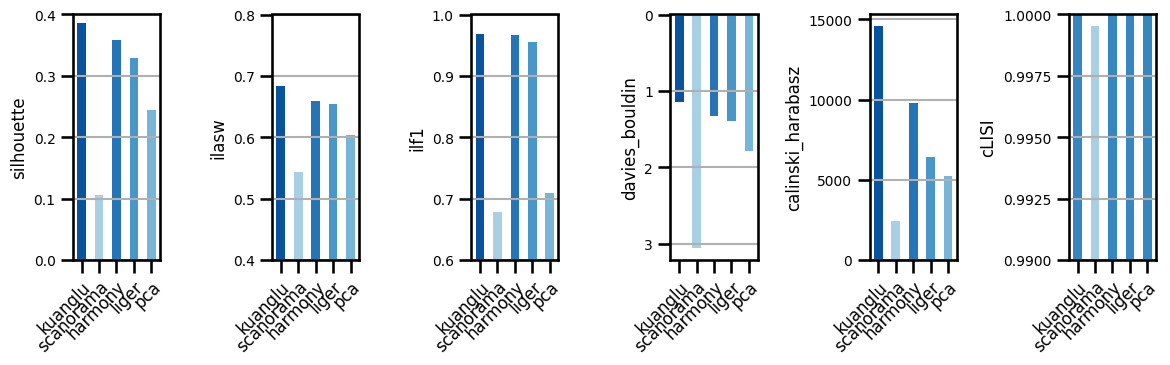

In [15]:
cmap = mpl.colormaps['Blues']
lower_is_better = ['davies_bouldin']
plt.subplots(1, scores.shape[1], figsize=(12, 4))
for i, v in enumerate(scores.columns):
    plt.subplot(1, scores.shape[1], i + 1)
    color = mpl.colormaps['Blues'](1 - scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    plt.yticks(size=10)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=12)
    
    dmin = scores[v].min()
    dmax = scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [0.99, 0.8, 0.6, 0.4, 0.2, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.2, 0.4, 0.6, 0.8, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
        
    if v in lower_is_better:
        plt.gca().invert_yaxis()
    
plt.tight_layout()

In [16]:
batch_scores = {}


for method in tqdm(methods):
    matrix_name = 'X_' + method
    
    if method in use_cosine:
        sc.pp.neighbors(adata, use_rep=matrix_name, metric='cosine')
    else:
        sc.pp.neighbors(adata, use_rep=matrix_name)
    
    sb = scib.me.silhouette_batch(adata, batch_key=batch, label_key=label, embed=matrix_name)
        
    gcb = scib.me.graph_connectivity(adata, label_key=label)
    
    ilisi = scib.me.ilisi_graph(adata, batch_key=batch, type_="knn")
    
    # kbet = scib.me.kBET(adata, batch_key=batch, label_key=label, type_="embed", embed=matrix_name)
    
    batch_scores[method] = [sb, gcb, ilisi]

  0%|                                                                                             | 0/5 [00:00<?, ?it/s]

mean silhouette per group:         silhouette_score
group                   
EXC             0.937980
INC             0.951871
lASC            0.941507
lMGC            0.937212
lOGC            0.913008
lOPC            0.959679
oENDO           0.954574
oMURAL          0.889153


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:         silhouette_score
group                   
EXC             0.970638
INC             0.954226
lASC            0.965066
lMGC            0.957883
lOGC            0.953156
lOPC            0.934452
oENDO           0.968139
oMURAL          0.958840


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:         silhouette_score
group                   
EXC             0.876944
INC             0.915357
lASC            0.903694
lMGC            0.917605
lOGC            0.867762
lOPC            0.902945
oENDO           0.925119
oMURAL          0.920814


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:         silhouette_score
group                   
EXC             0.901662
INC             0.925351
lASC            0.923383
lMGC            0.953960
lOGC            0.939352
lOPC            0.941253
oENDO           0.938253
oMURAL          0.904956


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

mean silhouette per group:         silhouette_score
group                   
EXC             0.935282
INC             0.918193
lASC            0.935336
lMGC            0.880766
lOGC            0.848379
lOPC            0.887486
oENDO           0.926231
oMURAL          0.927479


/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.org/devdocs/release/1.25.0-notes.html and the docs for more information.  (Deprecated NumPy 1.25)
  common = np.find_common_type([values.dtype, comps_array.dtype], [])
/home/lshh/miniconda3/envs/py39_scib/lib/python3.9/site-packages/pandas/core/algorithms.py:522: DeprecationWarning: np.find_common_type is deprecated.  Please use `np.result_type` or `np.promote_types`.
See https://numpy.o

In [17]:
batch_scores = pd.DataFrame(batch_scores, index=['silhouette_batch', 'graph_connectivity_batch', 'ilisi']).T

In [18]:
batch_scores = batch_scores.loc[['kuanglu', 'scanorama', 'harmony', 'liger', 'pca']]
batch_scores

,silhouette_batch,graph_connectivity_batch,ilisi
kuanglu,0.907394,0.994606,0.373678
scanorama,0.928521,0.993803,0.173560
harmony,0.957800,0.996032,0.415664
liger,0.935623,0.992532,0.522775
pca,0.903780,0.997065,0.033594


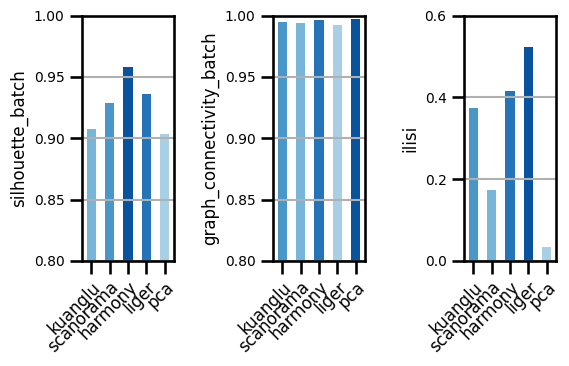

In [19]:
lower_is_better = [] # ['silhouette_batch', 'graph_connectivity_batch', 'ilisi']

plt.subplots(1, batch_scores.shape[1], figsize=(6, 4))
for i, v in enumerate(batch_scores.columns):
    plt.subplot(1, batch_scores.shape[1], i + 1)
    color = mpl.colormaps['Blues'](1 - batch_scores[v].rank(ascending=v in lower_is_better, pct=True) * .66)
    batch_scores[v].plot(kind='bar', color=color)
    plt.ylabel(v, size=12)
    plt.grid(axis='y')
    plt.yticks(size=10)
    plt.xticks(rotation=45, ha='right', rotation_mode='anchor', size=12)
    
    dmin = batch_scores[v].min()
    dmax = batch_scores[v].max()
    
    if dmin >= 0.0 and dmin <= 1.0 and dmax >= 0.0 and dmax <= 1.0:
        for vmin in [0.8, 0.6, 0.4, 0.2, 0.0]:
            if dmin > vmin:
                break
        for vmax in [0.2, 0.4, 0.6, 0.8, 1.0]:
            if dmax < vmax:
                break
        plt.ylim(vmin, vmax)
    
plt.tight_layout()

In [20]:
with open("output/human-brain-4000-judge-l1.pkl", 'wb') as f:
    pkl.dump([scores, batch_scores], f)